***HY473 - Pattern Recognition***

**Assignment 3**

**Part A: Maximum Likelihood Estimation for Parameter Estimation**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib import cm
import math

First, we have to load the `dataA_MLE.csv` file. Then, we have to **split the data** into three categories: 0, 1, and 2. Finally, for each category, **we keep only the two columns** with the features.

**Questions:**

1. Implement a function which takes as input **an array of samples** and returns the **mean** and the **covariance matrix** of those samples.


In [2]:
def calculate_mean_cov(samples):
    mean = np.mean(samples, axis=0)

    n_samples = samples.shape[0]
    cov = np.zeros((samples.shape[1], samples.shape[1]))

    for i in range(n_samples):
        cov += np.outer(samples[i] - mean, samples[i] - mean)

    cov /= n_samples

    return mean, cov

2. Print the **mean** and the **covariance** matrix for **each one** of the **3 classes**, using the function from Question 1.


In [4]:
def print_class_parameters(data):
    features = data[:, :2]
    labels = data[:, 2].astype(int)

    for class_id in range(3):
        class_samples = features[labels == class_id]

        mean, cov = calculate_mean_cov(class_samples)

        print(f"Class {class_id}:")
        print(f"  Mean: {mean}")
        print(f"  Covariance Matrix:")
        print(f"  {cov[0, 0]:.6f}, {cov[0, 1]:.6f}")
        print(f"  {cov[1, 0]:.6f}, {cov[1, 1]:.6f}")
        print()

data = np.loadtxt('dataA_MLE.csv', delimiter=',')
print("Class Parameters:")
print_class_parameters(data)

Class Parameters:
Class 0:
  Mean: [30.09647702 19.04632653]
  Covariance Matrix:
  38.439303, 36.440705
  36.440705, 47.419554

Class 1:
  Mean: [39.63449266 19.58127529]
  Covariance Matrix:
  7.007052, 8.514931
  8.514931, 18.814073

Class 2:
  Mean: [19.63607187 35.05220406]
  Covariance Matrix:
  15.829336, 7.377575
  7.377575, 20.816897



3. Considering the function of Question 1, **plot each class distribution** in one single 3D plot.

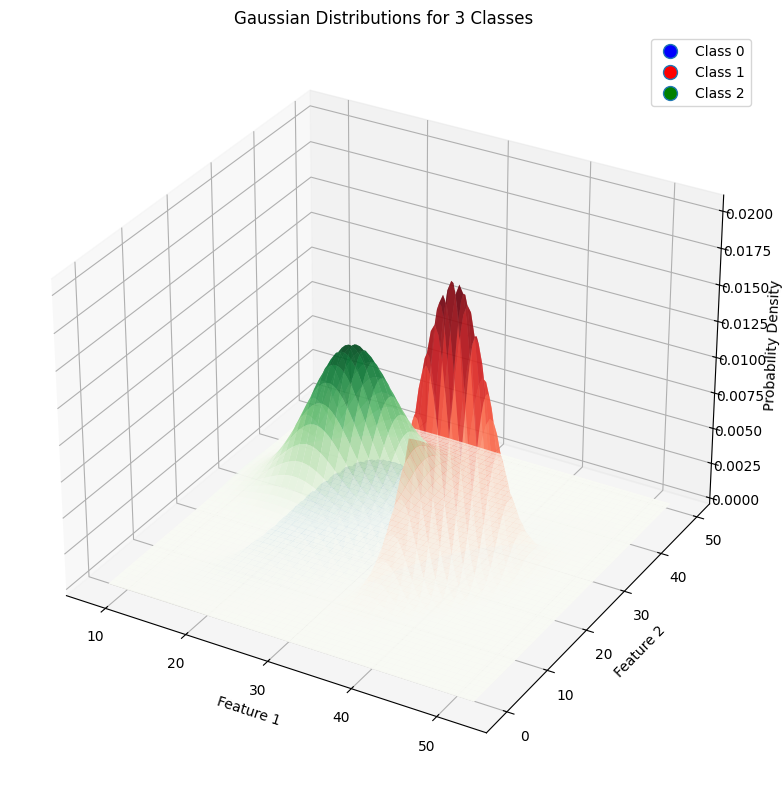

In [5]:
def plot_distributions(data):
    features = data[:, :2]
    labels = data[:, 2].astype(int)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    colors = ['blue', 'red', 'green']
    cmaps = [cm.Blues, cm.Reds, cm.Greens]

    for class_id in range(3):
        class_samples = features[labels == class_id]
        mean, covariance = calculate_mean_cov(class_samples)

        inv_covariance = np.linalg.inv(covariance)
        det_covariance = np.linalg.det(covariance)

        z = np.zeros_like(x)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                point = np.array([x[i, j], y[i, j]])
                diff = point - mean
                exponent = -0.5 * np.dot(np.dot(diff, inv_covariance), diff)
                z[i, j] = (1.0 / (2.0 * np.pi * np.sqrt(det_covariance))) * np.exp(exponent)

        surf = ax.plot_surface(x, y, z, cmap=cmaps[class_id], linewidth=0,
                              antialiased=True, alpha=0.7, label=f'Class {class_id}')

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], linestyle="none", marker='o', markersize=10,
                          markerfacecolor=colors[i]) for i in range(3)]

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Probability Density')
    ax.set_title('Gaussian Distributions for 3 Classes')
    ax.legend(custom_lines, ['Class 0', 'Class 1', 'Class 2'])

    plt.tight_layout()
    plt.show()

plot_distributions(data)

**Part B: Parzen Windows**

For this exercise, you will use the dataset included in `dataB_Parzen.csv` file. The dataset consists of 200 samples by row, each sample is 1-dimensional (1 column). **We do not have any knowledge or assumption about their distribution.**

**Questions:**

1. Implement the window function φ(u), when window is a **hypercube**.

In this case the window is hypercube. So,
$$\phi(u) =\begin{cases} 1 & \text{if } |u| \leq 0.5 \\
0 & \text{otherwise}
\end{cases}$$


In [6]:
def phi_function_hypercube(u):
  if abs(u) <= 0.5:
    return 1
  else:
    return 0

2. Implement the window function φ(u), when window is a **Gaussian kernel**.

For the gaussian:
$$
\phi(u) = \frac{1}{\sqrt{2\pi}} \cdot e^{-\frac{u^2}{2}}
$$


In [7]:
def phi_function_gaussian(u):
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * u ** 2)

3. Implement a function which takes as input a **single point xi**, **the center of the window** as a single point **c**, the **width h** of the window and the **kernel type** (’**hypercube**’ or ’**Gaussian**’) of the window. The function calls one of the above implemented functions (hypercube window or Gaussian window), with the appropriate input, and returns the result.


We first compute the **normalized distance**

$$u = \frac{xi - c}{h}$$ which:
- Centers the kernel at c by subtracting c from xi.
- Scales the distance by h to ensure the kernel's width (bandwidth) is consistent, regardless of the actual values of xi or c.

In [8]:
def kernel_function(xi, c, h, kernel_type):
    u = (xi - c) / h
    if kernel_type == 'hypercube':
        return phi_function_hypercube(u)
    elif kernel_type == 'Gaussian':
        return phi_function_gaussian(u)
    else:
        raise ValueError("Invalid kernel type. Use 'hypercube' or 'Gaussian'.")


4. In this question, you are asked to develop the **Density Function of Parzen Window**. Implement a function which takes as input an **array of 1-d points data**, a **single point x** which represents the center, the **width h** of the window and **the kernel type** of the window. The function should return **the likelihood** of the center x, given the other inputs.

The Parzen window estimate approximates the **true probability density function** (PDF) as:


$$
\hat{p}(x) = \frac{1}{n \cdot h} \sum_{i=1}^{n} K\left(\frac{x - x_i}{h}\right)
$$

Where:

- **K**: is the **kernel function** (e.g., hypercube or Gaussian).
- **n** is the **number of data** points.
- **h** is the **bandwidth** (window size).


In [9]:
def density_function_parzen(data, x, h, kernel_type):
  n = len(data)
  sum = 0
  for xi in data:
    sum += kernel_function(xi, x, h, kernel_type)
  likelihood = sum / (n * h)
  return likelihood

5. What’s the best value for the width of the window h? To find this, assume that the dataset you have comes from the normal distribution N(1, 1) (this is a univariate normal distribution). Find the most suitable value for h based on that knowledge.

(a) Create a **histogram of the data** to convince yourselves that they come from the aforementioned distribution.

(b) For **every h in the range** [0.05, 5] with step = 0.1 **calculate** 1) **the predicted likelihood** for every point in the data, 2) **their true likelihood** (you can use the function norm.pdf(data, loc=1, scale=1)), and 3) **the Mean Square Error** of the two likelihoods (predicted and true). Repeat this process for **both kernels** (hypercube and Gaussian). What’s the most suitable value for h for each kernel? **Print your answer** and **create a plot** which shows the values of h on the x-axis and their MSE on the y-axis (for both kernels).

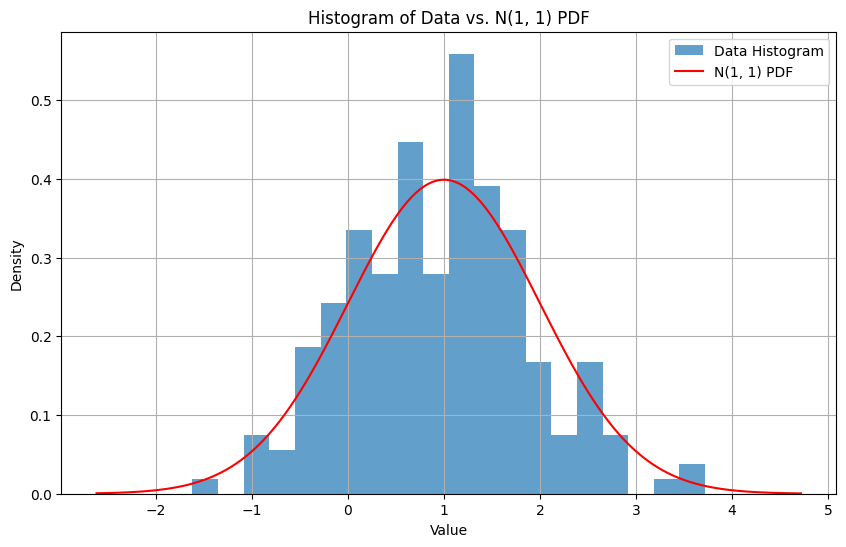

Best h value for hypercube kernel: 1.45
Best h value for Gaussian kernel: 0.45


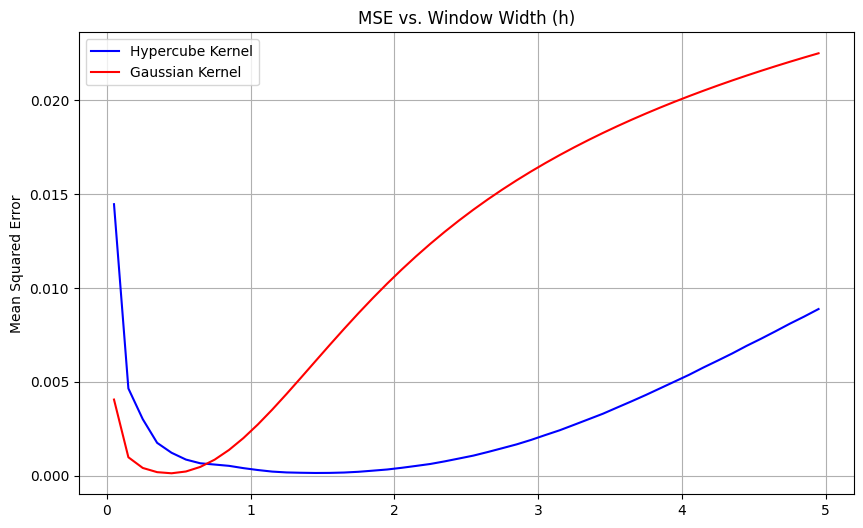

In [10]:
def true_pdf_values(x):
    return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - 1) ** 2))


def calculate_mse(data, eval_points, h, kernel_type):
    predicted_densities = np.array([density_function_parzen(data, x, h, kernel_type) for x in eval_points])
    true_densities = true_pdf_values(eval_points)
    mse = np.mean((predicted_densities - true_densities) ** 2)
    return mse


def find_optimal_h(data):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, density=True, alpha=0.7, label='Data Histogram')

    x_range = np.linspace(min(data) - 1, max(data) + 1, 1000)
    true_pdf = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_range - 1) ** 2))
    plt.plot(x_range, true_pdf, 'r-', label='N(1, 1) PDF')

    plt.title('Histogram of Data vs. N(1, 1) PDF')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    h_values = np.arange(0.05, 5.05, 0.1)
    mse_hypercube = []
    mse_gaussian = []

    eval_points = np.linspace(min(data) - 1, max(data) + 1, 200)

    for h in h_values:
        hypercube_mse = calculate_mse(data, eval_points, h, 'hypercube')
        mse_hypercube.append(hypercube_mse)

        gaussian_mse = calculate_mse(data, eval_points, h, 'Gaussian')
        mse_gaussian.append(gaussian_mse)

    best_h_hypercube = h_values[np.argmin(mse_hypercube)]
    best_h_gaussian = h_values[np.argmin(mse_gaussian)]

    print(f"Best h value for hypercube kernel: {best_h_hypercube:.2f}")
    print(f"Best h value for Gaussian kernel: {best_h_gaussian:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(h_values, mse_hypercube, 'b-', label='Hypercube Kernel')
    plt.plot(h_values, mse_gaussian, 'r-', label='Gaussian Kernel')

    plt.title('MSE vs. Window Width (h)')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()



data = np.loadtxt('dataB_Parzen.csv', delimiter=',')
find_optimal_h(data)


**Part C: K-Nearest Neighbors (KNN) Classification**

For this exercise, you will use the dataset included in `dataC_KNNtrain.csv` and `dataC_KNNtest.csv` files. Notice that each sample has 3 columns. The first 2 columns represent the **2-dimensional data** and the last column represents **their label (0,1)**.

In [11]:
train_data = np.loadtxt('dataC_KNNtrain.csv', delimiter=',')
test_data = np.loadtxt('dataC_KNNtest.csv', delimiter=',')

**Questions:**

1. Implement a function which has as input **a 2D point x** and a NumPy **array train_data** of 2D points, and it computes the **Euclidean distances of that point x to all points in the given array**. The function should **return** that NumPy **array** of the Euclidean distances.

**d_i** : The Euclidean distance between the given point  x  and the i -th point in `train_data`.  
**x_1, x_2:** Coordinates of the given point x (represented as \([x_1, x_2]\)).  
**x_{i1}, x_{i2}:** Coordinates of the i-th point in `train_data`.

$$
d_i = \sqrt{(x_1 - x_{i1})^2 + (x_2 - x_{i2})^2}
$$

In [12]:
def euclidean_distances(x, train_data):
  features = train_data[:, :2] #we want only the first 2 columns for the features
  distance = np.sqrt(np.sum((features - x) ** 2, axis=1))
  return distance

sample_point = test_data[0, :2]
distances = euclidean_distances(sample_point, train_data)
print(f"Distances from first test point to first 5 training points: {distances[:5]}")

Distances from first test point to first 5 training points: [15.47414941  9.25147556 16.26457808 16.03112597 12.82680007]


2. Implement a function which has as input a **2D point x**, a NumPy **array train_data** of 2D points and a **number k**. The function **returns the k closer neighbors of x**. As neighbors, we call all the points in train data. Hint: Use the function from Question 1.

In [13]:
def find_neighbors(x, train_data, k):
  distance = euclidean_distances(x, train_data)
  k_closer_neighbors = np.argsort(distance)[:k]
  return train_data[k_closer_neighbors]
#for example k=3
neighbors = find_neighbors(sample_point, train_data, k=3)
print(f"3 nearest neighbors of first test point:\n{neighbors}")

3 nearest neighbors of first test point:
[[20.13 28.25  0.  ]
 [20.51 27.81  0.  ]
 [20.31 27.06  0.  ]]


3. In this step, you are asked to develop the **k-NN algorithm**. Implement a function which has as input the **train data**, the **test data** and a **number k** of neighbors that will be considered during k-NN. The function should **return** two probabilities for each sample xi of the test data, **the probability of xi sample belong to class 0 and the probability of xi sample belong to class 1**, respectively. These probabilities should add to 1.

For **each test point**:

- We have to find its k nearest neighbors in the training data
- We have to count how many neighbors belong to each class
- We have to calculate probability of each class using this formula:

$$
P(\text{class}) = \frac{\text{count of neighbors in that class}}{k}
$$


In [14]:
def knn_algorithm(train_data, test_data, k):
  features = test_data[:, :2]
  probabilities = np.zeros((len(features), 2))
  for i, x in enumerate(features):
    neighbors = find_neighbors(x, train_data, k)
    labels = neighbors[:, 2]
    probabilities[i, 0] = np.sum(labels == 0) / k
    probabilities[i, 1] = np.sum(labels == 1) / k
  return probabilities

#for example k=5 to see if it works
probs = knn_algorithm(train_data, test_data[:5], k=5)
print(f"Probabilities for first 5 test points (k=5):\n{probs}")

Probabilities for first 5 test points (k=5):
[[1.  0. ]
 [0.2 0.8]
 [0.6 0.4]
 [1.  0. ]
 [1.  0. ]]


4. In this question, you are asked to **search for the best k number**, meaning to select a number k that **maximizes the accuracy of the k-NN classifier**. Compute the **accuracy**of the classifier from question 3, for each k in the set of{1,2,3,4,5,6,7,8,9,10,11,12,13,14,15}(e.g. acc=? whenk=3,...,acc=? when k = 11, ...). **Plot with point markers the above results**, **print** and **explain which k you would choose.**


For **each k value**:

- We have to apply KNN algorithm with that k value
- We hav to calculate accuracy using this formula:
$$
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{total number of test samples}}
$$
$$
\text{Accuracy} = \text{mean}(\text{predicted labels} == \text{true labels})
$$


k = 1: Accuracy = 0.8421
k = 2: Accuracy = 0.8333
k = 3: Accuracy = 0.8684
k = 4: Accuracy = 0.8684
k = 5: Accuracy = 0.8684
k = 6: Accuracy = 0.8684
k = 7: Accuracy = 0.8772
k = 8: Accuracy = 0.8772
k = 9: Accuracy = 0.8772
k = 10: Accuracy = 0.8860
k = 11: Accuracy = 0.8772
k = 12: Accuracy = 0.8860
k = 13: Accuracy = 0.8772
k = 14: Accuracy = 0.8947
k = 15: Accuracy = 0.8772

Best k: 14 with accuracy: 0.8947


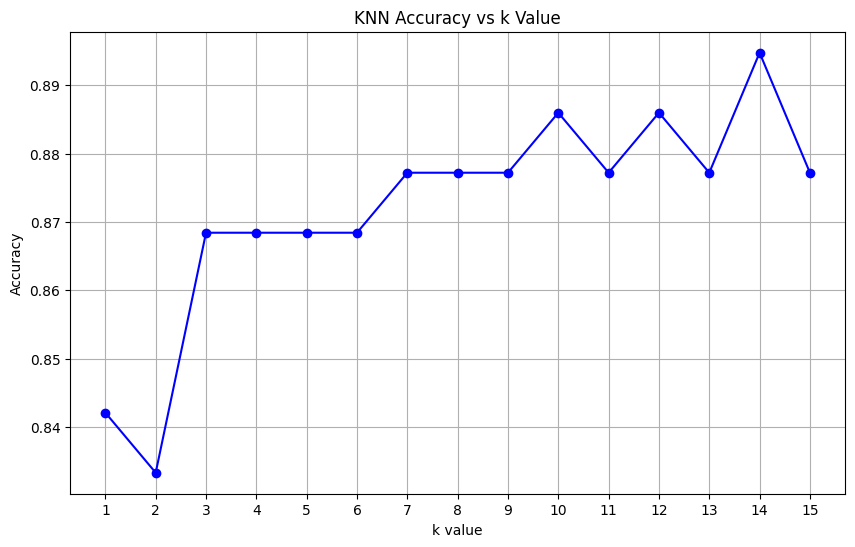

In [15]:
def find_best_k(train_data, test_data, k_values):
  labels = test_data[:, 2]
  accuracies = {}
  for k in k_values:
    probabilities = knn_algorithm(train_data, test_data, k)
    predicted_labels = np.argmax(probabilities, axis=1)
    accuracy = np.mean(predicted_labels == labels)
    accuracies[k] = accuracy
    print(f"k = {k}: Accuracy = {accuracy:.4f}")

  best_k = max(accuracies, key=accuracies.get)
  print(f"\nBest k: {best_k} with accuracy: {accuracies[best_k]:.4f}")

  plt.figure(figsize=(10, 6))
  plt.plot(list(accuracies.keys()), list(accuracies.values()), 'bo-')
  plt.xlabel('k value')
  plt.ylabel('Accuracy')
  plt.title('KNN Accuracy vs k Value')
  plt.xticks(k_values)
  plt.grid(True)
  plt.show()

  return accuracies, best_k

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracies, best_k = find_best_k(train_data, test_data, k_values)

 5. Show the decision boundaries of your classifier in a 2D plot, using the value for k from the previous task.

For **each point in the grid** we have to apply KNN to classify the point.

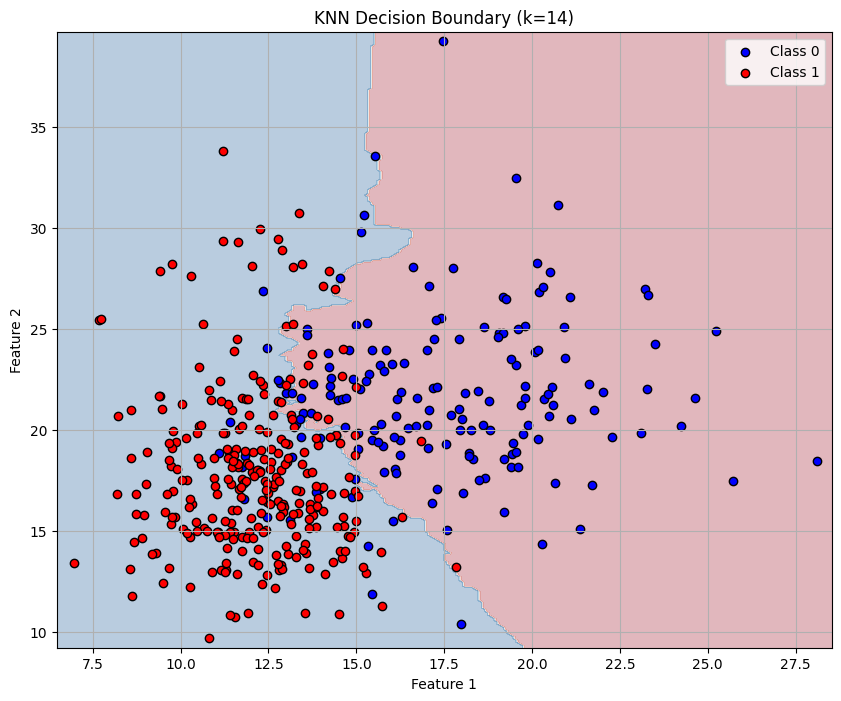

In [16]:
def decision_boundaries(train_data, k):
    X = train_data[:, :2]
    y = train_data[:, 2]

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.09),
                         np.arange(y_min, y_max, 0.09))

    points = np.c_[xx.ravel(), yy.ravel()]
    Z = np.zeros(points.shape[0])

    for i in range(points.shape[0]):
        neighbors = find_neighbors(points[i], train_data, k)
        neighbor_labels = neighbors[:, 2]
        Z[i] = 1 if np.sum(neighbor_labels == 1)/k > 0.5 else 0

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

    class_0 = X[y == 0]
    class_1 = X[y == 1]
    plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0', edgecolors='k')
    plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class 1', edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'KNN Decision Boundary (k={k})')
    plt.legend()
    plt.grid(True)
    plt.show()

decision_boundaries(train_data, best_k)

The plot effectively visualizes **how KNN partitions the feature space based on proximity to training samples**. The choice of **k=14** produces a reasonable boundary that captures underlying patterns without overfitting, making it a **suitable model** for this dataset.